<a href="https://colab.research.google.com/github/glory-ub/SCAMP-Assessment/blob/master/DSN_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
get_ipython().system('{sys.executable} -m pip install quandl')

In [ ]:
import pandas as pd
#import quandl as qd
import matplotlib.pyplot as plt
from matplotlib import style
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score
from sklearn.linear_model import LinearRegression
import datetime
from datetime import datetime
import pickle
style.use('ggplot')

#df1 = qd.get('WIKI/GOOGL')
#print(df1.tail())

In [ ]:
df = df1[['Adj. Open','Adj. Close','Adj. High','Adj. Low','Adj. Volume']]
df.loc[:,'HL_PCT'] = (df.loc[:,'Adj. High']-df.loc[:,'Adj. Low'])/df.loc[:,'Adj. Close']*100
df.loc[:,'PCT_change'] = (df.loc[:,'Adj. High']-df.loc[:,'Adj. Close'])/df.loc[:,'Adj. Close']*100

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [ ]:
print(df.head())

            Adj. Open  Adj. Close  Adj. High  ...  Adj. Volume    HL_PCT  PCT_change
Date                                          ...                                   
2004-08-19  50.159839   50.322842  52.191109  ...   44659000.0  8.072956    3.712563
2004-08-20  50.661387   54.322689  54.708881  ...   22834300.0  7.921706    0.710922
2004-08-23  55.551482   54.869377  56.915693  ...   18256100.0  4.049360    3.729433
2004-08-24  55.792225   52.597363  55.972783  ...   15247300.0  7.657099    6.417469
2004-08-25  52.542193   53.164113  54.167209  ...    9188600.0  3.886792    1.886792

[5 rows x 7 columns]


In [ ]:
df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.072956    3.712563   44659000.0
2004-08-20   54.322689  7.921706    0.710922   22834300.0
2004-08-23   54.869377  4.049360    3.729433   18256100.0
2004-08-24   52.597363  7.657099    6.417469   15247300.0
2004-08-25   53.164113  3.886792    1.886792    9188600.0


In [ ]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)
forecast_out = int(math.ceil(0.01*len(df)))
df['Label'] = df[forecast_col].shift(-forecast_out)
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume      Label
Date                                                                
2004-08-19   50.322842  8.072956    3.712563   44659000.0  69.078238
2004-08-20   54.322689  7.921706    0.710922   22834300.0  67.839414
2004-08-23   54.869377  4.049360    3.729433   18256100.0  68.912727
2004-08-24   52.597363  7.657099    6.417469   15247300.0  70.668146
2004-08-25   53.164113  3.886792    1.886792    9188600.0  71.219849


In [ ]:
X = np.array(df.drop(['Label'],1))
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_latest = X[-forecast_out:]
df.dropna(inplace=True)
y= np.array(df['Label'])
print(len(X),len(y))

3389 3389


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
clf = LinearRegression(n_jobs =-1)
train_fit = clf.fit(X_train, y_train)
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf,f)
pickle_in =  open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)
y_test_predict = clf.predict(X_test)
forecast_set = clf.predict(X_latest)
print(clf.score(X_test, y_test ))
print(cross_val_score(clf, X, y, cv=3))
#cross_val_score(y_test,y_test_predict)
#print(forecast_set, forecast_out)
df['forecast'] = np.nan
print(df.forecast)

0.9796138872248075
[0.55611934 0.82273492 0.80216138]
Date
2004-08-19   NaN
2004-08-20   NaN
2004-08-23   NaN
2004-08-24   NaN
2004-08-25   NaN
              ..
2018-01-30   NaN
2018-01-31   NaN
2018-02-01   NaN
2018-02-02   NaN
2018-02-05   NaN
Name: forecast, Length: 3389, dtype: float64


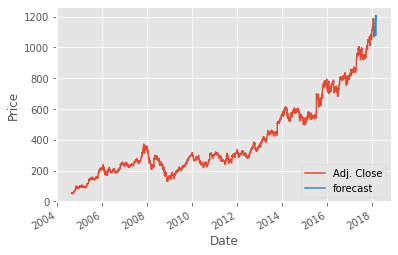

Date
2004-08-19            NaN
2004-08-20            NaN
2004-08-23            NaN
2004-08-24            NaN
2004-08-25            NaN
                 ...     
2018-03-08    1198.118244
2018-03-09    1202.994938
2018-03-10    1201.606262
2018-03-11    1137.386728
2018-03-12    1082.198512
Name: forecast, Length: 3424, dtype: float64


In [ ]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day
for i in forecast_set:
    next_date = datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]
#print(df.tail())

df['Adj. Close'].plot()
df['forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
print(df.forecast)

In [ ]:
#print(df.drop(['Label'],1).columns)
print(df.columns)


Index(['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume', 'Label',
       'forecast'],
      dtype='object')


In [ ]:
data = pd.DataFrame(list(range(1,100)))
data['1'] = data*2
data['1'] = data[:-20]
print(data)

     0    1
0    1  1.0
1    2  2.0
2    3  3.0
3    4  4.0
4    5  5.0
..  ..  ...
94  95  NaN
95  96  NaN
96  97  NaN
97  98  NaN
98  99  NaN

[99 rows x 2 columns]


In [ ]:
#X_latest
X_test

array([[-0.53358773, -0.43660654, -0.18904261, -0.03867677],
       [-0.45831731, -0.54221841, -0.92904908, -0.337658  ],
       [-0.62302487,  1.40231899,  2.14952379,  2.23950753],
       ...,
       [-0.45786974, -0.63636431,  0.02207463, -0.19021055],
       [-0.73054014,  0.07456336,  0.6041611 ,  0.66349319],
       [ 1.36210044, -0.40390557,  0.13361368, -0.79346559]])

In [ ]:
start = df.iloc[-1].name

In [ ]:

from datetime import datetime
from datetime import timedelta
end = df.iloc[-1].name + timedelta(days =forecast_out)
for i in pd.date_range(start, end):
    print(i)

2018-03-12 00:00:00
2018-03-13 00:00:00
2018-03-14 00:00:00
2018-03-15 00:00:00
2018-03-16 00:00:00
2018-03-17 00:00:00
2018-03-18 00:00:00
2018-03-19 00:00:00
2018-03-20 00:00:00
2018-03-21 00:00:00
2018-03-22 00:00:00
2018-03-23 00:00:00
2018-03-24 00:00:00
2018-03-25 00:00:00
2018-03-26 00:00:00
2018-03-27 00:00:00
2018-03-28 00:00:00
2018-03-29 00:00:00
2018-03-30 00:00:00
2018-03-31 00:00:00
2018-04-01 00:00:00
2018-04-02 00:00:00
2018-04-03 00:00:00
2018-04-04 00:00:00
2018-04-05 00:00:00
2018-04-06 00:00:00
2018-04-07 00:00:00
2018-04-08 00:00:00
2018-04-09 00:00:00
2018-04-10 00:00:00
2018-04-11 00:00:00
2018-04-12 00:00:00
2018-04-13 00:00:00
2018-04-14 00:00:00
2018-04-15 00:00:00
2018-04-16 00:00:00


In [ ]:
# linear regression algorithm from scratch
import numpy as np
from numpy import mean
import random
'''x = np.array(list(range(1,20)))
y = np.array(list(range(1,20)))*2'''

'x = np.array(list(range(1,20)))\ny = np.array(list(range(1,20)))*2'

In [ ]:
def best_fit_slope_and_intercept(x,y):
  m = (mean(x)*mean(y) - mean(x*y))/(mean(x)**2-mean(x**2))
  b = mean(y)-(m*mean(x))
  return m,b

In [ ]:
x = np.array([1,2,3,4,5,6])
y = np.array([5,4,6,5,6,7])
m,b =best_fit_slope_and_intercept(x,y)

In [ ]:
print(m,b)

0.42857142857142866 4.0


In [ ]:
regression_line = (m*x) + b

In [ ]:
print(regression_line)

[4.42857143 4.85714286 5.28571429 5.71428571 6.14285714 6.57142857]


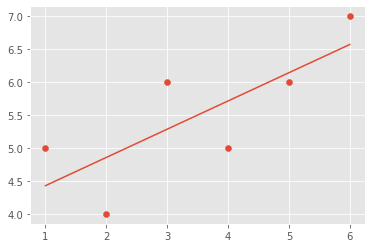

In [ ]:
plt.scatter(x,y)
plt.plot(x,regression_line)
plt.show()

In [ ]:
def squared_error(y_orig,y_line):
  return(sum((y_line - y_orig)**2))

def coeficient_determination(y_orig,y_line):
  y_mean_line = [mean(y_orig) for y_ in y_orig]
  squared_error_regres = squared_error(y_orig,y_line)
  squared_error_y_mean = squared_error(y_orig, y_mean_line)
  return 1 - (squared_error_regres / squared_error_y_mean)


In [ ]:
coeficient_determination(y,regression_line)

0.5844155844155845

In [ ]:
y_mean_line = [mean(y) for y_ in y]

In [ ]:
print(y_mean_line)

[5.5, 5.5, 5.5, 5.5, 5.5, 5.5]


In [ ]:
def create_dataset(hm,variance,step,correlation=False):
  val = 1
  y = []
  for i in range(hm):
    y_ = val + random.randrange(-variance,variance)
    y.append(y_)
    if correlation and correlation =='pos':
      val+=step
    elif correlation and correlation == 'neg':
      val-=step
  x = [i for i in range(len(y))]
  return np.array(x), np.array(y)


In [ ]:
x,y = create_dataset(40, 20000, 2, correlation='neg')
m,b =best_fit_slope_and_intercept(x,y)
regression_line = (m*x) + b
predict_8 = (m*8) + b

In [ ]:
coeficient_determination(y,regression_line)

0.02066184257774606

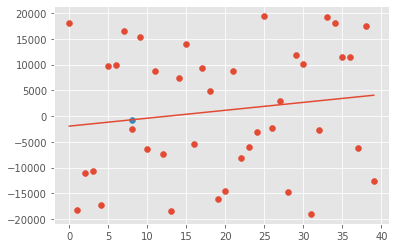

In [ ]:
plt.scatter(x,y)
plt.scatter(8,predict_8)
plt.plot(x,regression_line)
plt.show()

In [ ]:
# K-Nearest Neigbour from scratch

In [ ]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from collections import Counter
import warnings
style.use('fivethirtyeight')

In [ ]:
#euclidean_distance = math.sqrt( (plot1[0]-plot2[0])**2 + (plot1[1]-plot2[1])**2 )
#np.sqrt( np.sum((np.array(features)-np.array(predict))**2) )
dataset = {'k':[[1,2],[2,3],[3,1]], 'r':[[6,5],[7,7],[8,6]]}
new_features = [5,7]

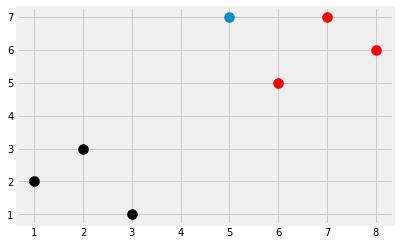

In [ ]:
[[plt.scatter(ii[0],ii[1], s=100, color=i) for ii in dataset[i]] for i in dataset]
plt.scatter(new_features[0],new_features[1], s=100)
plt.show()

In [ ]:
def k_nearest_neighbors(data, predict, k=3):
  global distances
  if len(data) >=k:
    warnings.warn('K is set tp a value less than total volting groups')
  distances = []
  for group in data:
    for features in data[group]:
      euclidean_distance = np.linalg.norm(np.array(features)-np.array(predict))
  distances.append([euclidean_distance,group])
  votes = [i[1] for i in sorted(distances)[:k]]
  print(Counter(votes).most_common(1))
  vote_result = Counter(votes).most_common(1)[0][0]
  return vote_result

In [ ]:
result = k_nearest_neighbors(dataset, new_features, k=3)
print(result)

[('r', 1)]
r


In [ ]:
distances

[[3.1622776601683795, 'r']]